In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest, mutual_info_regression
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.decomposition import PCA
# import models 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn import svm
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.preprocessing import LabelEncoder
import joblib

import warnings

warnings.filterwarnings("ignore")

## Load data files 

In [2]:

dataset_path = 'dataset.csv'
disease_description_path = 'disease_description.csv'
symptom_precaution_path = 'symptom_precaution.csv'
symptom_severity_path = 'symptom_severity.csv'

In [3]:
# Read the datasets
dataset = pd.read_csv(dataset_path)
disease_description = pd.read_csv(disease_description_path)
symptom_precaution = pd.read_csv(symptom_precaution_path)
symptom_severity = pd.read_csv(symptom_severity_path)


## View first two rows of the dictionary

In [4]:
datasets_info = {
    "Main Dataset": dataset,
    "Disease Description": disease_description,
    "Symptom Precaution": symptom_precaution,
    "Symptom Severity": symptom_severity
}

In [5]:
datasets_info['Disease Description'].head(2) # health conditions and descriptions 

,Disease,Description
0,Drug Reaction,An adverse drug reaction (ADR) is an injury ca...
1,Malaria,An infectious disease caused by protozoan para...


In [6]:
 datasets_info['Symptom Precaution'].head(2) # health conditions and Precautions

,Disease,Precaution_1,Precaution_2,Precaution_3,Precaution_4
0,Drug Reaction,stop irritation,consult nearest hospital,stop taking drug,follow up
1,Malaria,Consult nearest hospital,avoid oily food,avoid non veg food,keep mosquitos out


In [7]:
 datasets_info['Symptom Severity'].head(2) # Symptoms of health conditions and weight of severity of symptoms 

,Symptom,weight
0,itching,1
1,skin_rash,3


In [8]:
# Basic information about the datasets

In [9]:
# shapes of data
print( 'Rows     Columns\n',"_ _"*5)
print('Main dataset:')
print(f"{datasets_info['Main Dataset'].shape[0] }       {datasets_info['Main Dataset'].shape[1]} \n")
print('Symptom Precautions:')
print(f"{datasets_info['Symptom Precaution'].shape[0] }         {datasets_info['Symptom Precaution'].shape[1]}\n ")
print('Disease Description')
print(f"{datasets_info['Disease Description'].shape[0] }         {datasets_info['Disease Description'].shape[1]}\n ")
print('Symptom Severity')
print(f"{datasets_info['Symptom Severity'].shape[0] }          {datasets_info['Symptom Severity'].shape[1]} ")

Rows     Columns
 _ __ __ __ __ _
Main dataset:
4920       18 

Symptom Precautions:
41         5
 
Disease Description
41         2
 
Symptom Severity
133          2 


# clean datasets using functions

In [10]:
# Define a function to clean datasets by stripping whitespace, replacing unwanted characters, and filling NaN values with 'None'

def clean_datasets(datasets_info):
    cleaned_datasets = {}
    
    # Define a helper function to clean each DataFrame
    def clean_dataframe(df):
        # Strip whitespace, replace unwanted characters, and fill NaN values with 'None'
        df = df.applymap(lambda x: x.strip().replace('_', ' ') if isinstance(x, str) else x)
        df = df.fillna('None')
        return df
    
    # Loop through each dataset in the provided datasets_info dictionary
    for name, dataset in datasets_info.items():
        cleaned_datasets[name] = clean_dataframe(dataset)
    
    return cleaned_datasets


cleaned_datasets = clean_datasets({
    "Main Dataset": dataset,
    "Disease Description": disease_description,
    "Symptom Precaution": symptom_precaution,
    "Symptom Severity": symptom_severity
})


# Display the cleaned "Main Dataset" as an example
cleaned_datasets['Main Dataset'].head()

,Disease,Symptom_1,Symptom_2,Symptom_3,Symptom_4,Symptom_5,Symptom_6,Symptom_7,Symptom_8,Symptom_9,Symptom_10,Symptom_11,Symptom_12,Symptom_13,Symptom_14,Symptom_15,Symptom_16,Symptom_17
0,Fungal infection,itching,skin rash,nodal skin eruptions,dischromic patches,None,None,None,None,None,None,None,None,None,None,None,None,None
1,Fungal infection,skin rash,nodal skin eruptions,dischromic patches,None,None,None,None,None,None,None,None,None,None,None,None,None,None
2,Fungal infection,itching,nodal skin eruptions,dischromic patches,None,None,None,None,None,None,None,None,None,None,None,None,None,None
3,Fungal infection,itching,skin rash,dischromic patches,None,None,None,None,None,None,None,None,None,None,None,None,None,None
4,Fungal infection,itching,skin rash,nodal skin eruptions,None,None,None,None,None,None,None,None,None,None,None,None,None,None


# Model development

## Encode the categorical data using label encoder

In [11]:
# Initialize label encoder
label_encoder = LabelEncoder()
# # Encode the Disease column
cleaned_datasets['Main Dataset']['Disease'] = label_encoder.fit_transform(cleaned_datasets['Main Dataset']['Disease'])
# Fill missing values with 'None'

In [12]:
cleaned_datasets['Main Dataset']['Disease']

0       15
1       15
2       15
3       15
4       15
        ..
4915     0
4916     2
4917    38
4918    35
4919    27
Name: Disease, Length: 4920, dtype: int64

## Gather all symptom columns then extract unique symptom names from all symptom columns 

In [13]:
symptom_columns = [col for col in cleaned_datasets['Main Dataset'].columns if 'Symptom' in col]

# Extract unique symptom names from all symptom columns in the dataset
unique_symptoms = set()
for col in symptom_columns:
    unique_symptoms.update(dataset[col].dropna().unique())


# convert the set to list and sort ( excluding 'nan' if any)
unique_symptoms = sorted(list(unique_symptoms))
# initialize a binary dataframe to hold binary features
symptom_features = pd.DataFrame(0, index=dataset.index, columns=unique_symptoms)

# populate the binary features dataFrame: 1 if symptom is present, 0 otherwise
for index, row in dataset.iterrows():
    for col in symptom_columns:
        symptom = row[col]
        if pd.notna(symptom) and symptom in symptom_features.columns:
            symptom_features.at[index, symptom]= 1
transformed_data = pd.concat([dataset['Disease'], symptom_features], axis=1)
transformed_data.columns = transformed_data.columns.str.replace('_', ' ')

## Now combine symptom features with the disease label 

In [14]:
transformed_data.head()

,Disease,abdominal pain,abnormal menstruation,acidity,acute liver failure,altered sensorium,anxiety,back pain,belly pain,blackheads,...,watering from eyes,weakness in limbs,weakness of one body side,weight gain,weight loss,yellow crust ooze,yellow urine,yellowing of eyes,yellowish skin,itching
0,Fungal infection,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,Fungal infection,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Fungal infection,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,Fungal infection,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,Fungal infection,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [26]:
# Correlation of symptoms 

transformed_data1 = transformed_data

label_encoder = LabelEncoder()
transformed_data1['Disease'] = label_encoder.fit_transform(transformed_data1['Disease'])
disease_correlation = transformed_data.corr()
disease_correlation

,Disease,abdominal pain,abnormal menstruation,acidity,acute liver failure,altered sensorium,anxiety,back pain,belly pain,blackheads,...,watering from eyes,weakness in limbs,weakness of one body side,weight gain,weight loss,yellow crust ooze,yellow urine,yellowing of eyes,yellowish skin,itching
Disease,1.000000,0.154424,0.095695,0.058592,0.026033,0.156199,0.065083,-0.202974,0.221282,-0.227907,...,-0.202584,-0.164599,0.151938,0.078099,0.135060,0.091116,-0.013017,0.152406,0.010079,-0.151898
abdominal pain,0.154424,1.000000,-0.116670,-0.111995,0.298940,-0.079348,-0.079348,-0.113570,0.279030,-0.077184,...,-0.077184,-0.077184,-0.077184,-0.079348,0.021263,-0.079348,0.279030,0.527264,0.733180,0.263282
abnormal menstruation,0.095695,-0.116670,1.000000,-0.049227,-0.034877,-0.034877,-0.034877,-0.049920,-0.034877,-0.033926,...,-0.033926,-0.033926,-0.033926,0.680108,0.298557,-0.034877,-0.034877,-0.100977,-0.108023,-0.090534
acidity,0.058592,-0.111995,-0.049227,1.000000,-0.033480,-0.033480,-0.033480,-0.047919,-0.033480,-0.032566,...,-0.032566,-0.032566,-0.032566,-0.033480,-0.069477,-0.033480,-0.033480,-0.096931,-0.103694,-0.086906
acute liver failure,0.026033,0.298940,-0.034877,-0.033480,1.000000,-0.023720,-0.023720,-0.033951,-0.023720,-0.023073,...,-0.023073,-0.023073,-0.023073,-0.023720,-0.049224,-0.023720,-0.023720,0.345397,0.302010,-0.061573
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
yellow crust ooze,0.091116,-0.079348,-0.034877,-0.033480,-0.023720,-0.023720,-0.023720,-0.033951,-0.023720,-0.023073,...,-0.023073,-0.023073,-0.023073,-0.023720,-0.049224,1.000000,-0.023720,-0.068676,-0.073467,-0.061573
yellow urine,-0.013017,0.279030,-0.034877,-0.033480,-0.023720,-0.023720,-0.023720,-0.033951,-0.023720,-0.023073,...,-0.023073,-0.023073,-0.023073,-0.023720,-0.049224,-0.023720,1.000000,0.345397,0.302010,0.361723
yellowing of eyes,0.152406,0.527264,-0.100977,-0.096931,0.345397,-0.068676,-0.068676,-0.098295,-0.068676,-0.066802,...,-0.066802,-0.066802,-0.066802,-0.068676,0.072306,-0.068676,0.345397,1.000000,0.715405,0.173673
yellowish skin,0.010079,0.733180,-0.108023,-0.103694,0.302010,-0.073467,-0.073467,-0.105153,-0.073467,-0.071463,...,-0.071463,-0.071463,-0.071463,-0.073467,0.042338,-0.073467,0.302010,0.715405,1.000000,0.300936


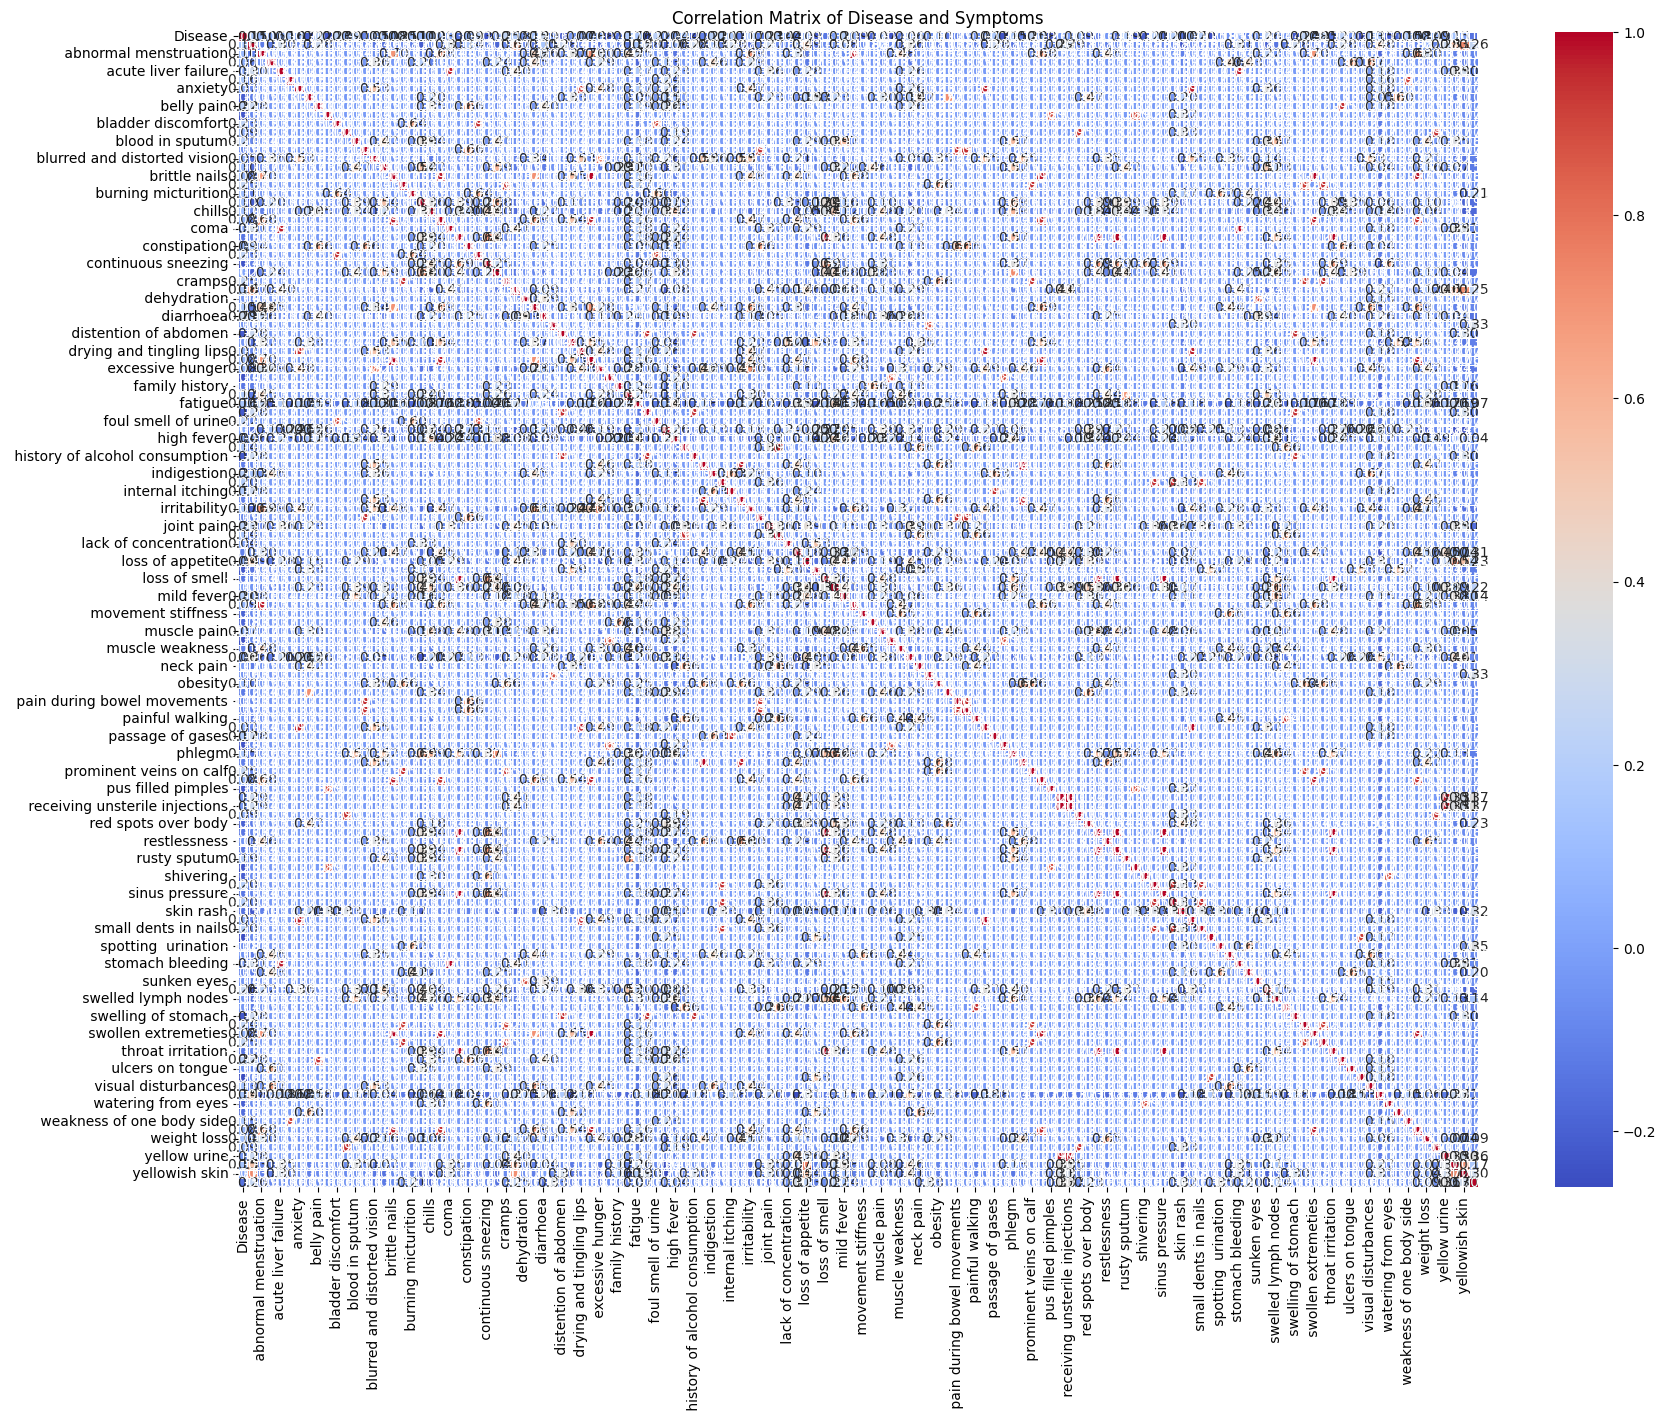

In [16]:
# Display the correlation matrix as a heatmap
# Increase the figure size for better readability
plt.figure(figsize=(20, 15))

# Create the heatmap with a larger figure and rotated x-axis labels
sns.heatmap(disease_correlation, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)

# Rotate the x-axis labels for better readability
plt.xticks(rotation=90)

# Title for the plot
plt.title('Correlation Matrix of Disease and Symptoms')

# Display the heatmap
plt.show()

## Determine principal compenents
# Perform PCA analysis 

In [17]:
# extract features
feature_df= transformed_data.drop(columns=['Disease']) # features
target= transformed_data['Disease'] # Target variables 

pca = PCA()
pca.fit(feature_df)

# Get variance ratios
variance_ratios = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(variance_ratios)

counter = 0

# Print feature names, explained variance, and cumulative variance for each feature
# Print header with aligned columns
print(f"{'Symptoms':<30}{'Individual Variance':<25}{'Component Count':<15}{'Cumulative Variance':<25}\n",'_'*90)

# Print feature names, explained variance, and cumulative variance for each feature
for feature_name, var_ratio, cum_var in zip(feature_df.columns, variance_ratios, cumulative_variance):
    counter += 1
    print(f"{feature_name:<30}{var_ratio:<28.5f}{counter:<20}{cum_var:<22.5f}")

Symptoms                      Individual Variance      Component CountCumulative Variance      
 __________________________________________________________________________________________
 abdominal pain               0.12421                     1                   0.12421               
 abnormal menstruation        0.10520                     2                   0.22941               
 acidity                      0.06844                     3                   0.29785               
 acute liver failure          0.06545                     4                   0.36330               
 altered sensorium            0.05211                     5                   0.41541               
 anxiety                      0.03872                     6                   0.45413               
 back pain                    0.03655                     7                   0.49068               
 belly pain                   0.03432                     8                   0.52500               
 bla

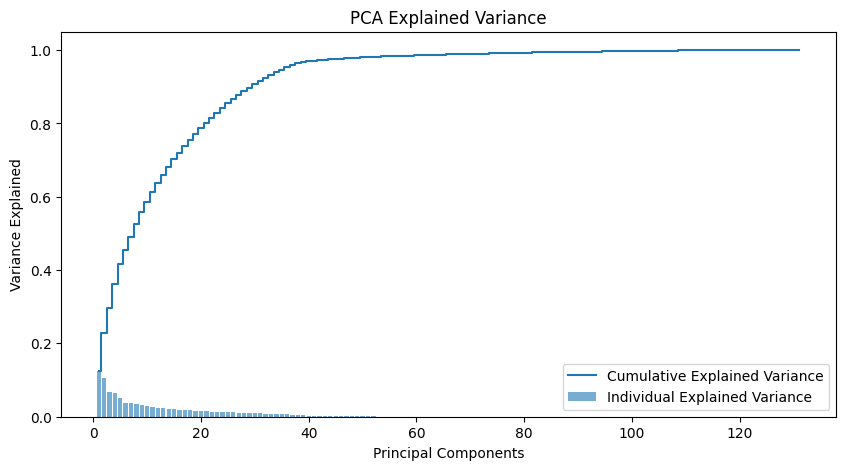

In [18]:
# Plot the variance explained by each component as well as accumulative variance 
plt.figure(figsize=(10, 5))

# Bar plot for individual variance ratios
plt.bar(range(1, len(variance_ratios) + 1), variance_ratios, alpha=0.6, label='Individual Explained Variance')

# Line plot for cumulative variance
plt.step(range(1, len(cumulative_variance) + 1), cumulative_variance, where='mid', label='Cumulative Explained Variance')

# Add labels and title
plt.xlabel('Principal Components')
plt.ylabel('Variance Explained')
plt.title('PCA Explained Variance')
plt.legend()
# Show plot
plt.show()


The cumulative variance explained by the principal components shows how much of the total dataset variance is captured as I include more components:
At 77th feature 99% of the dataset variance is explained.For completeness sick and medical certainty, I will iclude all features due to their presumptive significance 

# I will now compare some useful classification models to determine best performing models for fitting the data

In [19]:
# function to compare models 

models = [LogisticRegression(max_iter=1000), SVC(kernel='linear'),KNeighborsClassifier(),RandomForestClassifier(random_state=42),DecisionTreeClassifier(random_state=42) ]
def compare_models_cross_val():
    result =[]
    for model in models:
        cv_score = cross_val_score(model,feature_df,target, cv=5)
        mean_accuracy =sum(cv_score)/len(cv_score)
        mean_accuracy = round((mean_accuracy*100),2) # acuracy in percent rounded to 2 decimal places 
        print(f'Cross val accuracies for {model} = {cv_score}')
        print(f'Accurracy score of the {model} = {mean_accuracy} %')
              
        result.append({"Model": model, "Accuracy": mean_accuracy})
    
    # Convert results into a DataFrame
    result_df = pd.DataFrame(result)
    return result_df

# Call the function and print the results DataFrame # for standard scaling 
result_df = compare_models_cross_val()
result_df

Cross val accuracies for LogisticRegression(max_iter=1000) = [1. 1. 1. 1. 1.]
Accurracy score of the LogisticRegression(max_iter=1000) = 100.0 %
Cross val accuracies for SVC(kernel='linear') = [1. 1. 1. 1. 1.]
Accurracy score of the SVC(kernel='linear') = 100.0 %
Cross val accuracies for KNeighborsClassifier() = [1. 1. 1. 1. 1.]
Accurracy score of the KNeighborsClassifier() = 100.0 %
Cross val accuracies for RandomForestClassifier(random_state=42) = [1. 1. 1. 1. 1.]
Accurracy score of the RandomForestClassifier(random_state=42) = 100.0 %
Cross val accuracies for DecisionTreeClassifier(random_state=42) = [1. 1. 1. 1. 1.]
Accurracy score of the DecisionTreeClassifier(random_state=42) = 100.0 %


,Model,Accuracy
0,LogisticRegression(max_iter=1000),100.0
1,SVC(kernel='linear'),100.0
2,KNeighborsClassifier(),100.0
3,RandomForestClassifier(random_state=42),100.0
4,DecisionTreeClassifier(random_state=42),100.0


##### Based on these results, all models demonstrate excellent performance. However, I am a bit skeptical about overfitting 

##### I will utilize GridSearchCV to compare the models with different Hyperparameter values to further assess accuracy 

In [20]:
Models = [LogisticRegression(max_iter=10000), SVC(),KNeighborsClassifier(),RandomForestClassifier(random_state=42),DecisionTreeClassifier(random_state=42) ]

# I will create a dictionery that contains hyperparamter values for the above models 
hyper_params = {
    'log_reg_hyper_params': {
         'C': [1, 5, 10, 20]  # Corrected 'c' to 'C' to match scikit-learn's convention
    },
    'svc_hyper_params': {
        'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],  # Added a missing comma at the end of this line
        'C': [1, 5, 10, 20]  # Corrected 'c' to 'C' to match scikit-learn's convention
    },
    'knn_hyper_params': {
        'n_neighbors': [2, 3, 5, 10]
    },
    'random_forest_hyper_params': {
        'n_estimators': [10, 20, 50, 100]
    },
    'decision_tree_params': {
        'criterion': ['gini', 'entropy'],  # How to split at each node
        'max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
        'min_samples_split': [2, 10, 20],  # Minimum samples to split a node
        'min_samples_leaf': [1, 5, 10]  # Minimum samples in a leaf node
    }
        
    }
# create a list of keys for hyperparameters
model_keys = list(hyper_params.keys())
model_keys


['log_reg_hyper_params',
 'svc_hyper_params',
 'knn_hyper_params',
 'random_forest_hyper_params',
 'decision_tree_params']

In [21]:
#### Now I will apply GridSearchCV 
def selectModel(model_list, hyperparam_dict):
    results =[]
    i = 0
    for model in model_list:
        key = model_keys[i]
        params = hyperparam_dict[key]
        i += 1
        print(model)
        print(params)
        print('-------------'*5)
        classifier = GridSearchCV(model, params, cv=5)
        # Fit the data to the classifier
        classifier.fit(feature_df, target)
        results.append({
            'Model used': model.__class__.__name__, # Use model's class name for a cleaner output
            'Highest Score': classifier.best_score_,
            'Best hyperparameters': classifier.best_params_
        })

    results_df = pd.DataFrame(results, columns=['Model used', 'Highest Score', 'Best hyperparameters'])
    return results_df

In [22]:
# We can now apply hyper tunning 
selectModel(Models, hyper_params)

LogisticRegression(max_iter=10000)
{'C': [1, 5, 10, 20]}
-----------------------------------------------------------------
SVC()
{'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'C': [1, 5, 10, 20]}
-----------------------------------------------------------------
KNeighborsClassifier()
{'n_neighbors': [2, 3, 5, 10]}
-----------------------------------------------------------------
RandomForestClassifier(random_state=42)
{'n_estimators': [10, 20, 50, 100]}
-----------------------------------------------------------------
DecisionTreeClassifier(random_state=42)
{'criterion': ['gini', 'entropy'], 'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 10, 20], 'min_samples_leaf': [1, 5, 10]}
-----------------------------------------------------------------


,Model used,Highest Score,Best hyperparameters
0,LogisticRegression,1.0,{'C': 1}
1,SVC,1.0,"{'C': 1, 'kernel': 'linear'}"
2,KNeighborsClassifier,1.0,{'n_neighbors': 2}
3,RandomForestClassifier,1.0,{'n_estimators': 10}
4,DecisionTreeClassifier,1.0,"{'criterion': 'gini', 'max_depth': None, 'min_..."


Following hyper tunning, all models performed excellently. 

# Final Model Selection for Training and Testing : RandomForestClassifier


#### I use RandomForestClasifoer because of its:
#### Robustness: It averages across many decision trees, which makes it less prone to overfitting compared to a single decision tree.
#### Scalability: It can handle larger datasets better than models like KNeighborsClassifier and DecisionTreeClassifier.
#### Generalization: It typically generalizes better to new data due to its ensemble nature.

In [23]:
# Initialize RandomForestClassifier with the best hyperparameters
model_disase_prediction = RandomForestClassifier(n_estimators=10, random_state=42)
cv_scores = cross_val_score(model_disase_prediction,feature_df,target, cv=10, scoring='accuracy')
# mean and standard deviation of the cross-validation scores
cv_mean = cv_scores.mean()
cv_std = cv_scores.std()

print(f'CV mean {cv_mean}, CV standard deviation: {cv_std}, CV Scores:{cv_scores}')

CV mean 1.0, CV standard deviation: 0.0, CV Scores:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [24]:
x_train, x_test, y_train, y_test = train_test_split(feature_df,target, test_size=0.2, random_state=42)

# view test/train samples 
print(f'x Train: {x_train.shape[0]}, x test: {x_test.shape[0]}, y train:{y_train.shape[0]}, y test: {y_test.shape[0]}')

x Train: 3936, x test: 984, y train:3936, y test: 984


In [25]:
model_disase_prediction = RandomForestClassifier(random_state=42)

#parameter dictionary for model tunning
param_grid ={'n_estimators': [10, 20, 50, 100]}
disease_model_final = model_disase_prediction.fit(x_train,y_train)

# predict y test values using x test input
y_pred = disease_model_final.predict(x_test)
# Print classification report 
classification_report = classification_report(y_test, y_pred)
print(classification_report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        18
           1       1.00      1.00      1.00        30
           2       1.00      1.00      1.00        24
           3       1.00      1.00      1.00        25
           4       1.00      1.00      1.00        24
           5       1.00      1.00      1.00        23
           6       1.00      1.00      1.00        33
           7       1.00      1.00      1.00        23
           8       1.00      1.00      1.00        21
           9       1.00      1.00      1.00        15
          10       1.00      1.00      1.00        23
          11       1.00      1.00      1.00        26
          12       1.00      1.00      1.00        21
          13       1.00      1.00      1.00        29
          14       1.00      1.00      1.00        24
          15       1.00      1.00      1.00        19
          16       1.00      1.00      1.00        28
          17       1.00    